# Iterative $\alpha$-(de)blending
--------------------------------------
    Alfred PICHARD

## Table of Contents :
### 1. Application on a 2D point cloud generation   
      1.1 Simple MLP
      1.2 MLP in UNet with Positional Encoding

In [6]:
### IMOPRTS
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('dark_background')

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

import torchvision
from torch.utils.data import Dataset, DataLoader

from sklearn.datasets import make_swiss_roll
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## 1. Application on a 2D point cloud generation

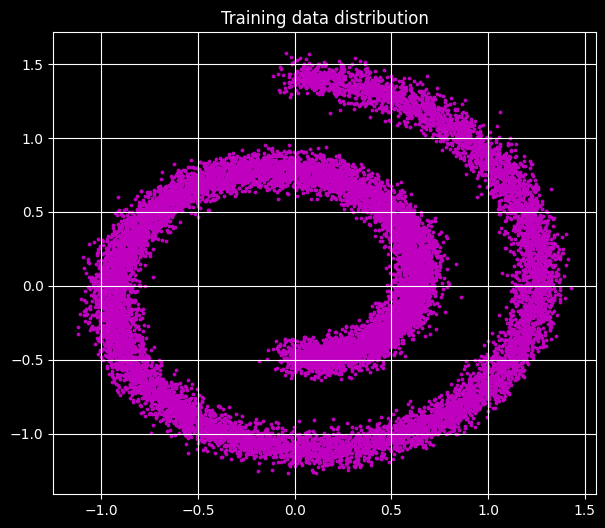

In [10]:
### Data preprocessing
def sample_batch(size, noise=0.6):
    x, _= make_swiss_roll(size, noise=noise)
    return x[:, [0, 2]] / 10.0

data = sample_batch(2**14).T

plt.figure(figsize=(7, 6))
plt.scatter(data[0], data[1], c='m', s=3)
plt.grid()
plt.title("Training data distribution")
plt.show()

In [11]:
### Training loop for alpha-(de)blending which can be used on all 2D point cloud generation models
def train(model, optimizer, criterion, dataset, batch_size):
    permutation = torch.randperm(dataset.size()[0])
    epoch_loss = 0.
    for i in range(0, dataset.size()[0], batch_size):
        indices = permutation[i:i+batch_size]
        optimizer.zero_grad()

        x_0 = torch.randn(batch_size, 2, device=device).float()
        x_1 = dataset[indices]
        alpha = torch.rand(batch_size, 1, device=device).float()
        x_alpha = (1-alpha) * x_0 + alpha * x_1

        output = model(x_alpha, alpha)
        target = x_1-x_0

        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        epoch_loss += loss

    return epoch_loss

### 1.1 Simple MLP

In [12]:
class AlphaDeblendMLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(3, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 2),
            nn.ReLU(),
        )
    
    def forward(self, x, alpha):
        x_alpha = torch.cat([x, alpha], dim=1)

        out = self.model(x_alpha)
        return out

In [15]:
BATCH_SIZE = 256
EPOCHS = 5000
LR = 0.001

model = AlphaDeblendMLP()
optimizer = optim.Adam(model.parameters(), lr=LR)
dataset = torch.tensor(data.T).float()
criterion = nn.MSELoss(reduction='mean')

### Train
for epoch in range(EPOCHS):
    epoch_loss = train(model, optimizer, criterion, dataset, BATCH_SIZE)

    if (epoch % 500 == 0):
        print(epoch_loss)

tensor(89.4615, grad_fn=<AddBackward0>)
tensor(75.8709, grad_fn=<AddBackward0>)
tensor(76.3923, grad_fn=<AddBackward0>)
tensor(75.9183, grad_fn=<AddBackward0>)
tensor(76.1567, grad_fn=<AddBackward0>)
tensor(76.4838, grad_fn=<AddBackward0>)
tensor(75.5553, grad_fn=<AddBackward0>)
tensor(74.8623, grad_fn=<AddBackward0>)
tensor(75.2791, grad_fn=<AddBackward0>)
tensor(75.9220, grad_fn=<AddBackward0>)


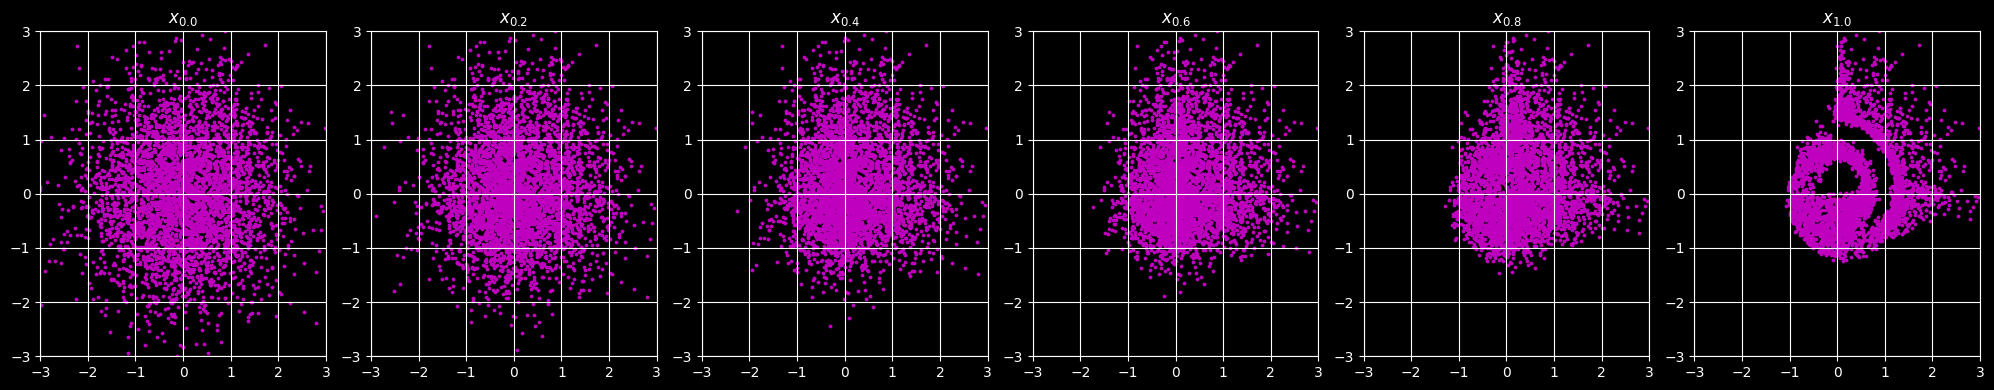

In [16]:
NUM_PLOTS = 5
BATCH_SIZE = 2**12
fig, axs = plt.subplots(1, NUM_PLOTS+1, figsize=(20,4))

with torch.no_grad():
    x_alpha = torch.randn(BATCH_SIZE, 2, device=device)

    T = 100
    for t in range(T+1):
        alpha = t/T * torch.ones(BATCH_SIZE, 1)
        x_alpha = x_alpha + (1/T)*model(x_alpha, alpha)

        if (t % (T//NUM_PLOTS) == 0):
            i = t//(T//NUM_PLOTS)
            axs[i].scatter(x_alpha.T[0], x_alpha.T[1], c='m', s=3)
            axs[i].set_title(f"$x_{{{'%.1f'%(alpha[0])}}}$")
            axs[i].set_xlim([-3, 3])
            axs[i].set_ylim([-3, 3])
            axs[i].grid(True)

    fig.tight_layout()
    plt.show()

### 1.2 MLP in UNET with Positional Encoding

In [17]:
### Modules Definition
class SinusoidalPositionalEncoder(nn.Module):
    def __init__(self, d_model, length=10000):
        super().__init__()
        self.d_model = d_model
        self.length = length

    def forward(self, x):
        pe = torch.zeros(self.length, self.d_model)
        position = torch.arange(0, self.length).unsqueeze(1)
        div_term = torch.exp((torch.arange(0, self.d_model, 2, dtype=torch.float) * -(np.log(10000.0) / self.d_model)))
        pe[:, 0::2] = torch.sin(position.float() * div_term)
        pe[:, 1::2] = torch.cos(position.float() * div_term)

        x = x + pe[:x.size(0)]
        return x


class LinearBlock(nn.Module):
    def __init__(self, hidden_dim, block_size):
        super().__init__()
        self.dense_hidden = [nn.Linear(hidden_dim, hidden_dim) for _ in range(block_size - 1)]

        self.relu = nn.ReLU()
    
    def forward(self, x):
        for layer in self.dense_hidden:
            x = self.relu(layer(x))

        return x


In [18]:
### MLP UNet Definition
class PositionLinearUNet(nn.Module):
    def __init__(self):
        super().__init__()
        # Input and Output
        self.input = nn.Linear(3, 64)
        self.output = nn.Linear(128, 2)

        # Encoder
        self.encoder_block_1 = LinearBlock(64, 2)
        self.encoder_block_2 = LinearBlock(32, 2)
        self.encoder_block_3 = LinearBlock(16, 2)
        self.downsample_1 = nn.Linear(64, 32)
        self.downsample_2 = nn.Linear(32, 16)

        # Decoder
        self.decoder_block_1 = LinearBlock(32, 2)
        self.decoder_block_2 = LinearBlock(64, 2)
        self.upsample_1 = nn.Linear(16, 32)
        self.upsample_2 = nn.Linear(32, 64)

        # Utils for skip connections
        self.positional_encoder_1 = SinusoidalPositionalEncoder(32)
        self.positional_encoder_2 = SinusoidalPositionalEncoder(64)
        self.relu = nn.ReLU()
    
    def forward(self, x, alpha):
        # Input
        x_alpha = torch.cat((x, alpha), dim=1)
        x_alpha = self.input(x_alpha)

        # Encode
        x1 = self.encoder_block_1(x_alpha)
        downsampled_x1 = self.relu(self.downsample_1(x1))
        x2 = self.encoder_block_2(downsampled_x1)
        downsampled_x2 = self.relu(self.downsample_2(x2))
        x3 = self.encoder_block_3(downsampled_x2)

        # Decode & connection skip
        decoded_x3 = self.upsample_1(x3)
        decoded_x2 = torch.cat((self.decoder_block_1(decoded_x3), self.positional_encoder_1(x2)), dim=1)
        decoded_x1 = torch.cat((self.decoder_block_2(decoded_x2), self.positional_encoder_2(x1)), dim=1)

        # Ouput
        out = self.output(decoded_x1)

        return out

In [19]:
### Hyperparamerters
BATCH_SIZE = 256
EPOCHS = 5000
LR = 0.001

position_linear_unet = PositionLinearUNet()
optimizer = optim.Adam(position_linear_unet.parameters(), lr=LR)
criterion = nn.MSELoss(reduction='mean')
dataset = torch.tensor(data.T).float()

### Train
for epoch in range(EPOCHS):
    epoch_loss = train(position_linear_unet, optimizer, criterion, dataset, BATCH_SIZE)

    if (epoch % 500 == 0):
        print(epoch_loss)

tensor(93.0302, grad_fn=<AddBackward0>)
tensor(62.9548, grad_fn=<AddBackward0>)
tensor(64.1779, grad_fn=<AddBackward0>)
tensor(63.7782, grad_fn=<AddBackward0>)
tensor(63.3569, grad_fn=<AddBackward0>)
tensor(62.8561, grad_fn=<AddBackward0>)
tensor(64.2200, grad_fn=<AddBackward0>)
tensor(63.6485, grad_fn=<AddBackward0>)
tensor(63.4573, grad_fn=<AddBackward0>)
tensor(63.0246, grad_fn=<AddBackward0>)


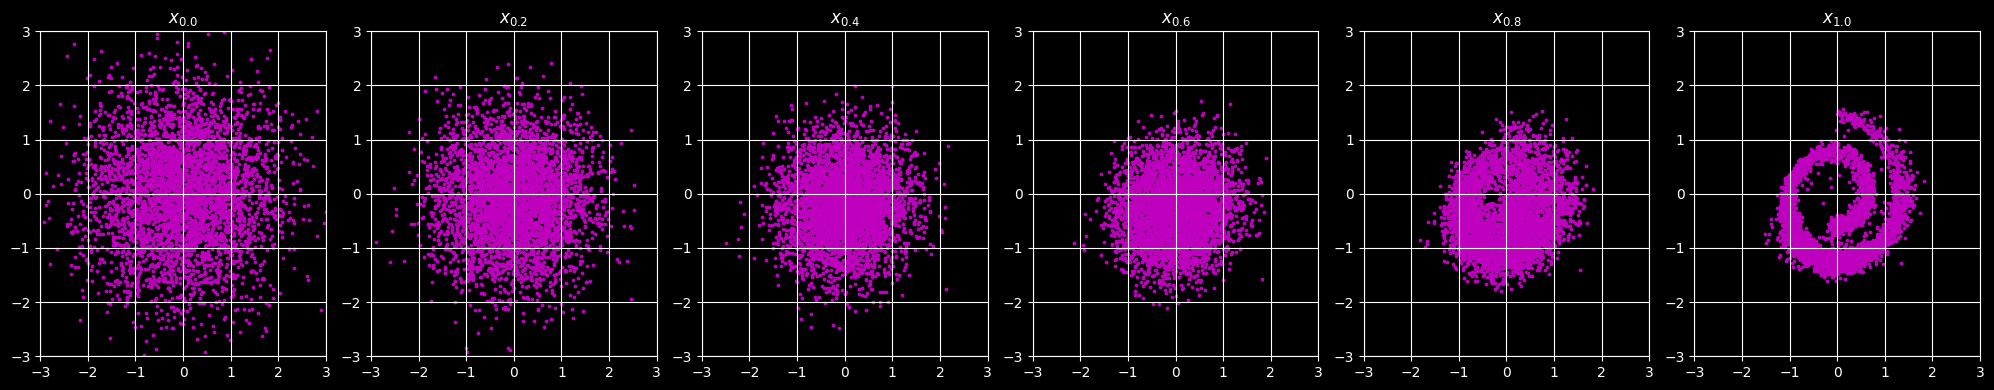

In [21]:
NUM_PLOTS = 5
BATCH_SIZE = 2**12
fig, axs = plt.subplots(1, NUM_PLOTS+1, figsize=(20,4))

with torch.no_grad():
    x_alpha = torch.randn(BATCH_SIZE, 2, device=device)

    T = 100
    for t in range(T+1):
        alpha = t/T * torch.ones(BATCH_SIZE, 1)
        x_alpha = x_alpha + (1/T) * position_linear_unet(x_alpha, alpha)

        # Visualize
        if (t % (T//NUM_PLOTS) == 0):
            i = t//(T//NUM_PLOTS)
            axs[i].scatter(x_alpha.T[0], x_alpha.T[1], c='m', s=3)
            axs[i].set_title(f"$x_{{{'%.1f'%(alpha[0])}}}$")
            axs[i].set_xlim([-3, 3])
            axs[i].set_ylim([-3, 3])
            axs[i].grid(True)

    fig.tight_layout()
    plt.show()

## References
- Eric Heitz, Laurent Belcour, and Thomas Chambon. Iterative alpha-(de) blending: a minimalist
deterministic diffusion model. https://arxiv.org/pdf/2305.03486.pdf
- Olaf Ronneberger, Philipp Fischer, and Thomas Brox. U-net: Convolutional networks
for biomedical image segmentation. https://arxiv.org/pdf/1505.04597.pdf